## Our Current Pace
| Date | Milestone |Description |
| ---- | --------- | ---------- 
| 3/12 | Free Recall | Characterize performance on regular free recall task
| 3/26 | Repetition | Characterize capacity to account for effect of item repetitions
| 4/2 | Semantics | Prove proposed distinctions are real (or not!) by relating models to relevant existing data sets.
| 4/9 or 4/16 | Practice | Compile and present practice presentation to lab
| 4/21 | Present | Cogsci seminar presentation
| 4/30 | Draft | Paper draft ready for Sean's review + committee meeting

Today we want to get the bulk of needed work done for the repetition section, plus get some preparatory work done for the seminar presentation.

## Holdovers From Previous Milestone
There's also stuff from previous weeks I still wanted to tackle. The main ones include:
- **Fit model(s) across list lengths**. Success accounting for performance independent of list length was a major milestone in model development historically.
- **Should probably look at different data sets**. Any from MortPolyn2016. The one with the most data. This is because the Murdoch dataset has some quirks.
- **Quantitative fit comparison**. AIC can do the work; MortPolyn2016 models how to do this.

We'll gradually address them as we also tackle the "high points" corresponding to each relevant milestone.

## Modeling Across List Lengths
We modified our likelihood functions to accept multiple trials arrays and list lengths to support fitting. No surprising results were obtained otherwise; ICMR and CMR are still at least apparently neck-and-neck. Modifying these functions did slow down the fitting code a little, though, even in the single `trials` condition. Speeds are still acceptable, though.

### CMR
```
     fun: 50697.92288549975
 message: 'Optimization terminated successfully.'
    nfev: 9441
     nit: 55
 success: True
       x: array([5.90422803e-01, 5.33541229e-02, 7.94015489e-01, 2.56195624e-01,
       8.60968980e-01, 1.45279643e-01, 6.54923908e+00, 4.20183468e+01,
       1.32345570e-02, 3.03551385e-01, 4.37106316e+00])
```

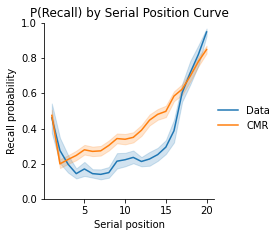

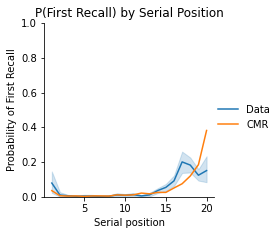

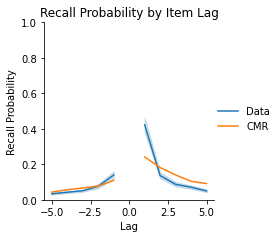

In [ ]:
parameters = {
    'item_count': murd_length0,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

visualize_fit(CMR, {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
        murd_events0, 'subject > -1', experiment_count=1000, savefig=True)

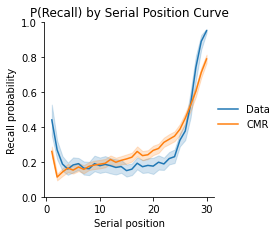

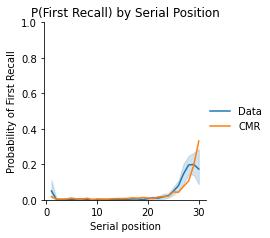

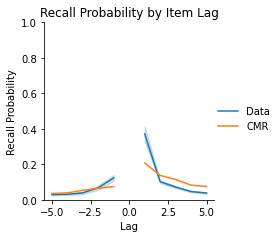

In [ ]:
parameters = {
    'item_count': murd_length1,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

visualize_fit(CMR, {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
        murd_events1, 'subject > -1', experiment_count=1000, savefig=True)

### InstanceCMR
```
     fun: 50845.0936809554
 message: 'Optimization terminated successfully.'
    nfev: 11916
     nit: 71
 success: True
       x: array([7.05068428e-01, 1.69545358e-02, 7.73285088e-01, 3.30627833e-03,
       3.62254512e-01, 2.57261169e-01, 4.57960201e+00, 3.52306107e+01,
       4.60031508e-02, 1.86046249e-01, 1.71344249e+00])
```

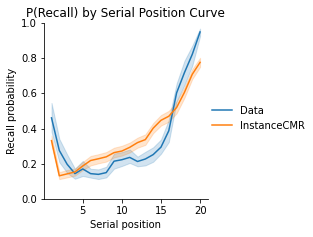

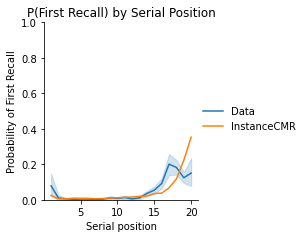

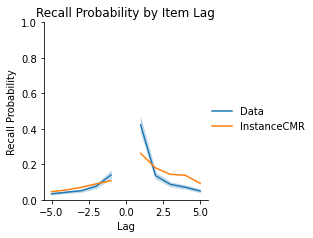

In [ ]:
parameters = {
    'item_count': murd_length0,
    'presentation_count': murd_length0,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

visualize_fit(InstanceCMR, {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
        murd_events0, 'subject > -1', experiment_count=1000, savefig=True)

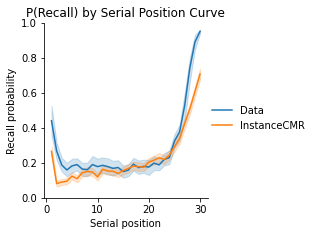

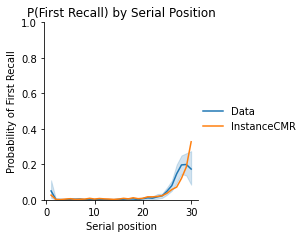

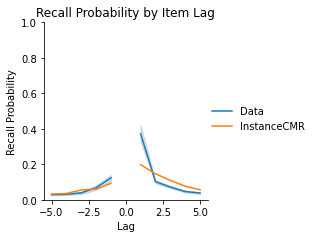

In [ ]:
parameters = {
    'item_count': murd_length1,
    'presentation_count': murd_length1,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

visualize_fit(InstanceCMR, {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
        murd_events1, 'subject > -1', experiment_count=1000, savefig=True)

## Modeling Repetitions
There are some signs that InstanceCMR and CMR track the consequences of item repetitions for free recall differently. Here, using the dataset associated with a 2014 paper focused on spacing and repetition effects in free recall, 

> Lohnas, L. J., & Kahana, M. J. (2014). A retrieved context account of spacing and repetition effects in free recall. Journal of Experimental Psychology: Learning, Memory, and Cognition, 40(3), 755.

We'll investigate these possible differences and develop an account of them. Before I get into the datasets, I'll try to test my intuitions about how repetitions drive learning between the two models w/ some toy simulations plotting how recall probabilities change as items are repeatedly encoded. Once that's cleared up, I'll do the fitting and assess outcomes.

### Premise

There seems to be substantive differences in the way CMR and ICMR apply a sensitivity parameter to nonlinearly increase the gap between highly supported and less supported recall outcomes. InstanceCMR, like MINERVA 2, has the option to apply its sensitivity scaling operation (i.e. an exponent to each value) to activations of individual traces - that is, before integration into a unitary vector tracking retrieval support. CMR, on the other hand, has no access to any trace activations and thus applies its sensitity scaling to the integrated result. 

The latter operation is hypothesized to more strongly differentiate strongly from weakly supported items than the former. Suppose a constant sensitivity parameter $\tau$ and that two distinct experiences each contributed a support of $c$ for a given feature unit in the current recall. Under trace-based sensitivity scaling, the retrieval support for that feature unit would be $c^{\tau} + c^{\tau}$. But under echo-based sensitity scaling, support would be ${(c + c)}^{\tau}$, a much larger quantity. 

When feature representations associated with each presentation encoded into models are all orthogonal, this distinction doesn't emerge. Since each trace corresponds to activation of a unique feature unit, no equivalent of the $c^{\tau} + c^{\tau}$ operation from the above example ever emerges. But experiments where items are presented repeatedly offer an opportunity to explore this distinction. It could be that parameter fitting avoids any of the main consequences for this mechanism difference, much as InstanceCMR and CMR learn similar retrieval dynamics despite implementing distinct associative networks with distinct learning algorithms. And alternatively it could be that more subtle manipulations, such as the use of partially overlapping rather than identical-but-otherwise-orthogonal feature representations, could explore this mechanistic distinction more thoughtfully. We'll see!

### Model Changes

Much of InstanceCMR's structure assumes that each item in a list will be presented once. For example, it pre-allocates space for exactly `item_count` objects and presumes `trace_index` will correspond with `item_index` in static ways. Furthermore, our likelihood function presumes each item will be experienced just once, and sequentially. So we had to modify/expand the model and helper functions substantially to support modeling item repetitions. We'll likely have to make similar extensions when we consider semantic representations.

#### Echo-Driven Outcome Probabilities
We previously assigned outcome_probabilities by matching traces to items and pooling same-item traces' activations into a single recall support scalar quantity. This was a lot different from how CMR works, which largely just converts its version of a memory echo directly into a set of probabilities. Making CMR and ICMR's outcome_probabilities function mostly identical doesn't seem to impact InstanceCMR's performance, and sidesteps the challenge of matching traces to items when items aren't presented in a known order.

It's also a bit cleaner? 

#### An Extra Presentation_Count Parameter
Like item_count, we'll never fit this, so in some key ways, it's not a real parameter. But we use it so the model can pre-allocate space in our memory array for a set of experiences that may exceed the number of items.

`CMR` doesn't need this parameter since it doesn't simulate any trace accumulation.

#### Specialized Likelihood Functions
We'll need specialized likelihood functions that don't assume items will be encoded in the same ordered sequence at each trial. We'll keep the old likelihood function for datasets without this added complexity. We could change our minds about this later.

### Simulation Results: Echo vs Trace-Based Sensitivity
Whether we apply the sensitivity scaling to CMR's or ICMR's 'echo', the outcome is exponential increase in recall support for a repeated item over each repetition. On the other hand, when the sensitivity scaling is applied to traces, the result is far more linear. That's a difference that makes a difference.

repeated item:
 16 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
cue:
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74086594 0.77125165 0.46822515
 0.04179596 0.47550837 0.85079944 0.47947188 0.69035978 0.26204846
 0.27861084 0.94345454 0.94960361 0.54584315 0.97023054 0.43642358
 0.6566589  0.96748338 0.2160465  0.68803062 0.83758537 0.04497364]
outcome probability for repeated item:
 [0.05135301 0.08316484 0.11035052 0.13607964 0.16147033 0.18697156
 0.21273548 0.23874411 0.2648793  0.29097106 0.31683199 0.34228065
 0.36715595 0.3913246  0.41468352 0.43715891 0.4587035  0.47929263
 0.49892031 0.51759526 0.53533745 0.55217506 0.56814204 0.58327606
 0.59761692 0.61120537 0.62408212 0.63628726 0.6478597  0.65883688
 0.66925455 0.67914664 0.68854523 0.69748052 0.70598088 0.71407288
 0.72178139 0.72912965

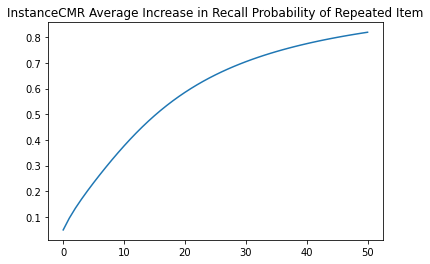

In [ ]:
results = np.zeros((experiment_count, 1+parameters['presentation_count']-parameters['item_count']))

for experiment in range(experiment_count):
    # arbitrary item and contextual cue
    repeated_item = np.random.randint(parameters['item_count'])
    cue = np.concatenate((np.zeros(parameters['item_count']+1), np.random.rand(parameters['item_count']+1)))

    # initialize model
    model = InstanceCMR(**parameters)
    model.experience(np.eye(parameters['item_count'], parameters['item_count'] + 1, 1))
    results[experiment, 0] = model.outcome_probabilities(cue)[repeated_item+1]
    
    # track outcome probability of selected item as it is repeatedly encoded
    for i in range(parameters['presentation_count']-parameters['item_count']):
        
        model.experience([np.eye(parameters['item_count'], parameters['item_count'] + 1, 1)[repeated_item]])
        
        # cue = np.concatenate((np.zeros(parameters['item_count']+1), model.context)) # for when i want context to be the cue
        results[experiment, i+1] = model.outcome_probabilities(cue)[repeated_item+1]

# plot an example trial    
print('repeated item:\n', repeated_item, np.eye(parameters['item_count'], parameters['item_count'] + 1, 1)[repeated_item])
print('cue:\n', cue)
print('outcome probability for repeated item:\n', results[-1])
#plot_states(model.memory, "memory")

plt.plot(np.mean(results, axis=0))
plt.title('InstanceCMR Average Increase in Recall Probability of Repeated Item')
plt.show()

repeated item:
 12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
cue:
 [0.07378284 0.04021591 0.64048461 0.51892809 0.01711629 0.7264126
 0.87151395 0.9006205  0.38396427 0.71709911 0.94784319 0.53735921
 0.3542203  0.49172688 0.9231446  0.13043689 0.47209734 0.76085019
 0.94421792 0.52581507 0.17915717]
outcome probability for repeated item:
 [0.05234194 0.15397587 0.29236728 0.43624206 0.56355938 0.66588265
 0.74380944 0.80164362 0.84421468 0.87562248 0.89898544 0.9165619
 0.92995427 0.94029327 0.94837898 0.9547817  0.95991186 0.96406814
 0.96747037 0.97028224 0.97262702 0.97459854 0.97626899 0.97769448
 0.978919   0.97997738 0.98089742 0.98170149 0.98240772 0.98303092
 0.98358325 0.98407479 0.98451392 0.98490763 0.98526185 0.98558155
 0.98587098 0.98613375 0.98637298 0.98659133 0.98679112 0.98697434
 0.98714275 0.98729787 0.98744103 0.98757341 0.98769605 0.98780985
 0.98791565 0.98801415 0.988106  ]


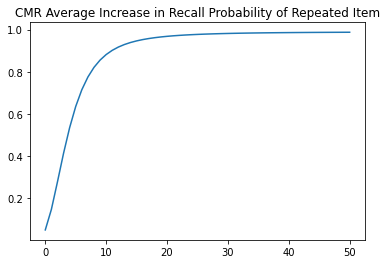

In [ ]:
results = np.zeros((experiment_count, 1+parameters['presentation_count']-parameters['item_count']))

for experiment in range(experiment_count):
    # arbitrary item and contextual cue
    repeated_item = np.random.randint(parameters['item_count'])
    cue = np.random.rand(parameters['item_count'] + 1)

    # initialize model
    model = CMR(**parameters)
    model.experience(np.eye(parameters['item_count'], parameters['item_count']))
    results[experiment, 0] = model.outcome_probabilities(cue)[repeated_item+1]
    
    # track outcome probability of selected item as it is repeatedly encoded
    for i in range(parameters['presentation_count']-parameters['item_count']):
        
        model.experience([np.eye(parameters['item_count'], parameters['item_count'])[repeated_item]])
        
        #cue = model.context # for when i want context to be the cue
        results[experiment, i+1] = model.outcome_probabilities(cue)[repeated_item+1]
        
# plot an example trial    
print('repeated item:\n', repeated_item, np.eye(parameters['item_count'], parameters['item_count'])[repeated_item])
print('cue:\n', cue)
print('outcome probability for repeated item:\n', results[-1])
#plot_states(model.mcf, "memory")

import matplotlib.pyplot as plt

plt.plot(np.mean(results, axis=0))
plt.title('CMR Average Increase in Recall Probability of Repeated Item')
plt.show()